<a href="https://colab.research.google.com/github/mrinalinimurugan/Tensorflow-with-Keras/blob/main/04_tf_transferlearning_part1_featureextraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Transfer learning with tensorflow Part 1: Feature Extraction

!nvidia-smi


Wed Sep  1 08:42:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Download and become one with the data
#GEt data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-09-01 08:42:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  76.4MB/s    in 2.1s    

2021-09-01 08:42:44 (76.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
#How may images in each folder
import os
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [23]:
#setting up callbacks

import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard logfiles to : {log_dir}")
  return tensorboard_callback

In [24]:
#Creating models using tensorflow hub

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [25]:
#Lets make a create_model(). function to create a model from a URL
def create_model(model_url,num_classes=10):
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature_extraction_layer",
                                            input_shape = IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
                               feature_extraction_layer,
                               layers.Dense(num_classes,activation="softmax",name="output_layer")

  ])

  return model

  
  

In [26]:
#Create resnet model

resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [27]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [28]:
#Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [29]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                 validation_data = test_data,
                 validation_steps=len(test_data),
                 steps_per_epoch=len(train_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")]
                 )

Saving tensorboard logfiles to : tensorflow_hub/resnet50V2/20210901-090337
Epoch 1/5
24/24 [==============================] - 59s 1s/step - loss: 1.9185 - accuracy: 0.3613 - val_loss: 1.1738 - val_accuracy: 0.6312
Epoch 2/5
24/24 [==============================] - 22s 953ms/step - loss: 0.9098 - accuracy: 0.7213 - val_loss: 0.8849 - val_accuracy: 0.7148
Epoch 3/5
24/24 [==============================] - 22s 960ms/step - loss: 0.6308 - accuracy: 0.8267 - val_loss: 0.7558 - val_accuracy: 0.7604
Epoch 4/5
24/24 [==============================] - 22s 955ms/step - loss: 0.4774 - accuracy: 0.8800 - val_loss: 0.7060 - val_accuracy: 0.7692
Epoch 5/5
24/24 [==============================] - 23s 964ms/step - loss: 0.3851 - accuracy: 0.9040 - val_loss: 0.6851 - val_accuracy: 0.7744


In [34]:
#Create function to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

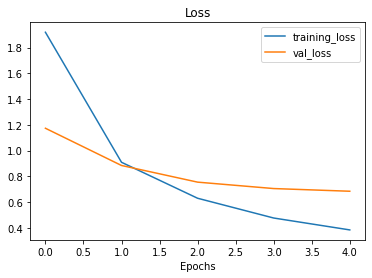

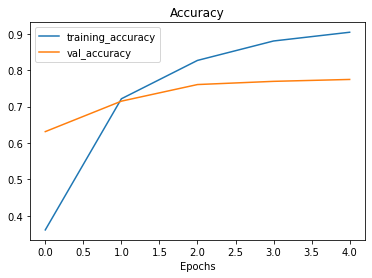

In [35]:
plot_loss_curves(resnet_history)

In [36]:
#Efficient NEt model creation

efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [37]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [38]:
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [39]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=5,
                 validation_data = test_data,
                 validation_steps=len(test_data),
                 steps_per_epoch=len(train_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="efficientnetb0")]
                 )

Saving tensorboard logfiles to : tensorflow_hub/efficientnetb0/20210901-093104
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.8139 - accuracy: 0.4800 - val_loss: 1.2563 - val_accuracy: 0.7480
Epoch 2/5
24/24 [==============================] - 19s 826ms/step - loss: 1.0322 - accuracy: 0.7760 - val_loss: 0.8481 - val_accuracy: 0.8232
Epoch 3/5
24/24 [==============================] - 20s 842ms/step - loss: 0.7446 - accuracy: 0.8347 - val_loss: 0.6873 - val_accuracy: 0.8516
Epoch 4/5
24/24 [==============================] - 19s 829ms/step - loss: 0.5975 - accuracy: 0.8707 - val_loss: 0.6018 - val_accuracy: 0.8560
Epoch 5/5
24/24 [==============================] - 19s 821ms/step - loss: 0.5079 - accuracy: 0.8960 - val_loss: 0.5489 - val_accuracy: 0.8648


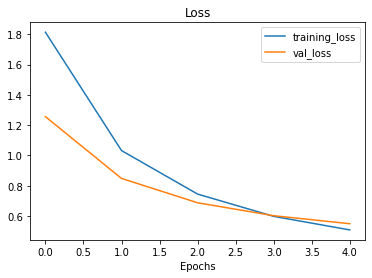

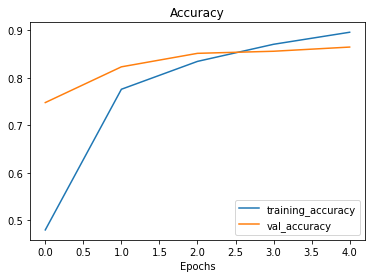

In [40]:
plot_loss_curves(efficientnet_history)

In [41]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [42]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [44]:
len(efficientnet_model.layers[0].weights)

309

In [47]:
#Comparing our models results using TensorBoard

#Upload tensorboard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing 2 different TF Hub feature extraction model architectures using 10% of training data" \
  --one_shot

2021-09-01 09:58:19.732318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-01 09:58:19.740560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-01 09:58:19.741065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/dLfNCryzQOSlVKo48N1Blw/

[2021-09-01T09:58:19] Started scanning logdir.
[2021-09-01T09:58:22] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.7 MB)
[2021-09-01T09:58:22] Done scanning logdir.


Done. View your TensorBoard at https://tensorboar

In [48]:
#View list of exxperiments
!tensorboard dev list

2021-09-01 10:04:17.146110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-01 10:04:17.158068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-01 10:04:17.158518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/dLfNCryzQOSlVKo48N1Blw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing 2 different TF Hub feature extraction model architectures using 10% of training data
	Id                   dLfNCryzQOSlVKo48N1Blw
	Created              2021-09-01 09:58:19 (6 minutes ago)
	Updated 

In [49]:
#Delete an expperiment
#!tensorboard dev delete experiment_id dLfNCryzQOSlVKo48N1Blw

In [50]:
#Confirm deletion
#!tensorboard dev list